In [1]:
#-------------------------
# Libs
#-------------------------
 
# External libs
# %matplotlib qt         Fuck this line right here.
import pymysql.cursors
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.neural_network import MLPRegressor as mlp
sys.path.append("/home/omalleyian/Documents/energy_market_project/scripts")
from ercot_data_interface import ercot_data_interface
from ARIMA import ARIMA

In [2]:
#-------------------------
# SQL environments
#-------------------------
 
HOST = "localhost"
USER = "root" 
PASSWORD = "Is79t5Is79t5"
DB = "ercot_data"

#-------------------------
# Functions
#-------------------------
"""
Make a connection to MySQL
Execute the MySQL query and return the resutls
"""

def execute_dict_query(query):
    connection = pymysql.connect(host=HOST, 
                                 user=USER, 
                                 password=PASSWORD, 
                                 db=DB, 
                                 port=3306,
                                 cursorclass=pymysql.cursors.DictCursor)
    
    try:
        with connection.cursor() as cursor:
            # Create a new record
            cursor.execute(query)
            result = cursor.fetchall()
            return result
    finally:
        connection.close()

 


In [24]:
def mape(actual, forcast):
    x = (np.asarray(actual)).flatten()
    y = (np.asarray(forcast)).flatten()
    return np.mean(np.square((x - y) / x))

def mae(actual, forcast):
    x = (np.asarray(actual)).flatten()
    y = (np.asarray(forcast)).flatten()
    return np.mean((x - y))

In [3]:
# Query data sorted by date and hour. SLOW!
result_dict = execute_dict_query('select * from DAM_LMP0  \
                                where delivery_date < "2016-12-31" \
                                and delivery_date > "2011-01-01" \
                                order by delivery_date, hour_ending')

In [4]:
#Extract some data
prices1 = [i['n0001VICTOR'] for i in result_dict]
prices2 = [i['n0001'] for i in result_dict]
hours = [i['hour_ending'].total_seconds() for i in result_dict]
dates = [i['delivery_date'] for i in result_dict]
plt.plot(prices1)
plt.plot(prices2)
# plt.show()

In [5]:
# Percent Change
k = 24
p_t = np.array(prices1[k:])
p_tk = np.array(prices1[:-k])
v = np.log10(p_t) - np.log10(p_tk)
plt.plot(v)
# plt.show()

# MAPE = mean( (actual - forcast) / actual)

MAPE = np.mean(np.square(p_t-p_tk)/p_t)

In [6]:
# Basic data plot
price1 = [float(i['AMNCOWD_8']) for i in result_dict]
price2 = [float(i['AZLES_K']) for i in result_dict]
price3 = [float(i['n0001']) for i in result_dict]

plt.plot(price1, label='1')
plt.plot(price2, label='2')
plt.plot(price3, label='2')
plt.legend()
# plt.show()


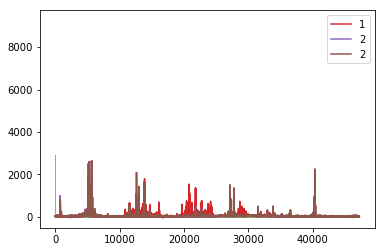

In [7]:
# Histogram
plt.hist(price1, 500)
plt.show()

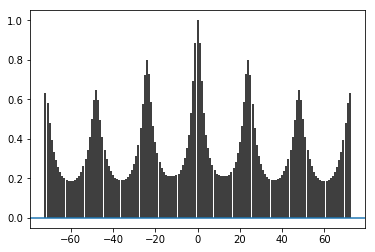

In [8]:
# Autocorrelation
plt.acorr(price1, maxlags=72)
plt.show()

In [9]:
np.mean(price1)

42.479072428819229

In [10]:
#extend this to get prices at different lags e.g. k-1, k-2, k-3
max_lag = 168
p_t = prices1[max_lag:]
X = []
for k in np.arange(0, max_lag, 24):
    t_k = np.array(prices1[(max_lag-k):-k], dtype='float')
    X.append(t_k)
X = np.swapaxes(np.array(X[1:]), 0, 1)
Y = [float(i) for i in p_t]
# use sklearn.LinearRegression to fit (X, Y)

regr = linear_model.LinearRegression()
regr.fit(X,Y)

print regr.predict(X)
plt.plot(X)
# plt.show()


[ 27.76918254  26.23065003  25.4826624  ...,  22.29701492  19.54565128
  17.51651262]


In [11]:
# Mean Model
# Given list X and time t
# Return mean of X from 0 to t

def mean_model(X, t):
    return np.mean(X[:t])

training = prices1[:-24]
test = prices1[-24:]

#MAPE  = np.mean()

print mean_model(training, 24)



29.52041666666666666666666667


In [12]:
# Random Walk Model
# Given list X and time t
# Return element of X at time t-1

def random_walk(X, t):
    return X[t-1]

print random_walk(prices1, 24)

30.14


In [13]:
# Moving Average Model
# Given a list X, time t, and m number of observations
# Return the value of Y at time t of the previous m elements in X.

def moving_average(X, t, m):
    s = sum(X[(t-m):t])
    avg = s/m
    return avg

print moving_average(prices1, 24, 24)
    
    

29.52041666666666666666666667


In [14]:

ercot = ercot_data_interface(password="Is79t5Is79t5")
nodes_crr = ercot.get_CRR_nodes()
nodes_all = ercot.all_nodes
nodes_source = ercot.get_sources_sinks()
df_2011 = ercot.query_prices(nodes_all[0], "2011-01-01","2011-12-31")
df_2012 = ercot.query_prices(nodes_all[0], "2012-01-01","2012-12-31")
matrix_2011 = df_2011.as_matrix()
matrix_2012 = df_2012.as_matrix()

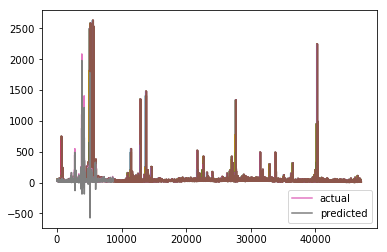

5.15112524169


In [15]:
arima = ARIMA(p = 2, d = 0, q = 0, seasonal = 24)
arima.fit(matrix_2011)
arima.plot_predicted_vs_actual(matrix_2012)
print arima.mae(matrix_2012)

In [16]:
# Arima Forcasting

# First split data into subsets offset by 24, and fit ARIMA models to these subsets.
hours_2011 = []
hours_2012 = []
arima_models = []

for i in range(24):
    ind_2011 = np.arange(i,matrix_2011.shape[0],24)
    ind_2012 = np.arange(i,matrix_2012.shape[0],24)
    
    hours_2011.append(matrix_2011[ind_2011])
    hours_2012.append(matrix_2012[ind_2012])
    
    arima = ARIMA(p = 2, d = 0, q = 1, seasonal = 1)
    arima.fit(matrix_2011[ind_2011])
    arima_models.append(arima)
    
print np.mean(matrix_2011)

46.2137045115


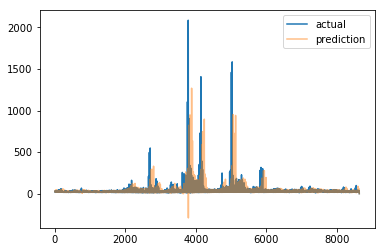

Merged MAE: 0.0946134854136


In [34]:
# Make predictions with the ARIMA models
# Merge the predictions into a single array to be ploted against actual data
predictions = []
merged_prediction = np.zeros(8640)
merged_actual = np.zeros(8640)
for i in range(len(arima_models)):
    prediction, actual = arima_models[i].predict(hours_2012[i])
    prediction = prediction.squeeze().tolist()
    actual = actual.squeeze().tolist()
    
    if len(prediction) < 360:
        prediction.extend(np.zeros(1))
        actual.extend(np.zeros(1))
    
    for j in range(len(prediction)):
        front = [0] * i
        back = [0] * (23-i)
        index = j * 24
        
        prediction[index:index] = front
        actual[index:index] = front
        
        prediction[index+i+1:index+i+1] = back
        actual[index+i+1:index+i+1] = back
        
    merged_prediction += prediction
    merged_actual += actual

plt.plot(merged_actual, label='actual')
plt.plot(merged_prediction, label='prediction', alpha=0.5)
plt.legend()
plt.show()

print "Merged MAE: " + str(mae(merged_actual, merged_prediction))

In [35]:
# Calculate mape for various models on the first 5 nodes
for i in range(5):
    print "MAE Calculation on Node" + str(i) + ": " + str(nodes_all[i])
    # Load training and testing data from a node
    df_train = ercot.query_prices(nodes_all[i], "2011-01-01","2015-05-23")
    df_test = ercot.query_prices(nodes_all[i], "2015-05-23","2016-05-23")
    matrix_train = df_train.as_matrix()
    matrix_test = df_test.as_matrix()
    
    # Preform mean model calculations on data
    m = np.mean(matrix_train)
    m_matrix = [m] * len(matrix_test)
    mae_mean = mae(matrix_test, m_matrix)
#     print "\tMean Model: " + str(mae_mean)
    print mae_mean
    
    # Perform random walk model calculations on data
    walk = matrix_test[:-1]
    walk_test = matrix_test[1:]
    mae_walk = mae(walk_test, walk)
#     print "\tRandom Walk: " + str(mae_walk)
    print mae_walk
    
    # ARIMA(2,0,1,1)
    arima = ARIMA(p = 2, d = 0, q = 1, seasonal = 1)
    arima.fit(matrix_train)
#     print "\tARIMA(2,0,1): " + str(arima.mae(matrix_test))
    print arima.mae(matrix_test)
    
    # ARIMA(2,0,2,1)
    arima = ARIMA(p = 2, d = 0, q = 2, seasonal = 1)
    arima.fit(matrix_train)
#     print "\tARIMA(2,0,2): " + str(arima.mae(matrix_test))
    print arima.mae(matrix_test)
    
    # ARIMA(2,0,3,1)
    arima = ARIMA(p = 2, d = 0, q = 3, seasonal = 1)
    arima.fit(matrix_train)
#     print "\tARIMA(2,0,3): " + str(arima.mae(matrix_test))
    print arima.mae(matrix_test)
    
    # ARIMA(2,0,1,24)
    arima = ARIMA(p = 2, d = 0, q = 1, seasonal = 24)
    arima.fit(matrix_train)
#     print "\tARIMA(2,0,3): " + str(arima.mae(matrix_test))
    print arima.mae(matrix_test)
    
    # ARIMA(2,0,2,24)
    arima = ARIMA(p = 2, d = 0, q = 2, seasonal = 24)
    arima.fit(matrix_train)
#     print "\tARIMA(2,0,3): " + str(arima.mae(matrix_test))
    print arima.mae(matrix_test)
    
    # ARIMA(2,0,3,24)
    arima = ARIMA(p = 2, d = 0, q = 3, seasonal = 24)
    arima.fit(matrix_train)
#     print "\tARIMA(2,0,3): " + str(arima.mae(matrix_test))
    print arima.mae(matrix_test)
    
    print "\n"

MAE Calculation on Node0: n0001
-13.985013189
-0.00122059831012
6.01805819353
5.39706807032
5.40431546301
4.64561583655
3.87516181568
3.90294122872


MAE Calculation on Node1: n0001DUPV1_
-11.6668910237
-0.000968257593058
6.29829840461
5.69998459251
5.68425432225
4.60772457965
3.83390918582
3.87478070077


MAE Calculation on Node2: n0001HWFG1
-10.5679988774
-0.000996802923042
5.99649032169
5.40740903601
5.43120320197
4.74642986664
3.9821791535
3.99743613373


MAE Calculation on Node3: n0001VICTOR
-11.6383515389
-0.000968257593058
6.28610132208
5.68090241465
5.66724372322
4.5988533252
3.8239151965
3.86331488156


MAE Calculation on Node4: n0001_C
16.0316525268
-0.00096369034026
7.00844410661
6.30533105504
5.95605161231
4.76691113955
4.13372785248
4.13585242456




In [21]:
df_train = ercot.query_prices(nodes_all[0], "2011-01-01","2015-05-23")
df_test = ercot.query_prices(nodes_all[0], "2015-05-23","2016-05-23")
matrix_train = df_train.as_matrix()
matrix_test = df_test.as_matrix()

In [23]:
arima = ARIMA(p = 2, d = 0, q = 1, seasonal = 1)
arima.fit(matrix_train)
print str(arima.mae(matrix_test))
arima = ARIMA(p = 2, d = 0, q = 2, seasonal = 1)
arima.fit(matrix_train)
print str(arima.mae(matrix_test))
arima = ARIMA(p = 2, d = 0, q = 3, seasonal = 1)
arima.fit(matrix_train)
print str(arima.mae(matrix_test))
print "\n"

arima = ARIMA(p = 2, d = 0, q = 3, seasonal = 20)
arima.fit(matrix_train)
print str(arima.mae(matrix_test))

6.01805819353
5.39706807032
5.40431546301


8.26266024725


In [ ]:
# # The Arima Prediction method drops 4 elements of the input list
# arima = ARIMA(p = 2, d = 0, q = 1, seasonal = 1)
# arima.fit(matrix_train)
# p, a = arima.predict(matrix_test)
# mape_arima = mape(p, matrix_test)